In [2]:
import argparse
import os
import ast
import pickle
import sys
import time
import torch
from torch.utils.data import WeightedRandomSampler
basepath = os.path.dirname(os.path.dirname(sys.path[0]))
sys.path.append(basepath)
import dataloader
import models
import numpy as np
from traintest import train, validate
%matplotlib inline

import matplotlib.pyplot as plt
from models import ASTModel
# download pretrained model in this directory
os.environ['TORCH_HOME'] = '../pretrained_models'
# assume each input spectrogram has 100 time frames
input_tdim = 100
# assume the task has 527 classes
label_dim = 527
# create a pseudo input: a batch of 10 spectrogram, each with 100 time frames and 128 frequency bins
test_input = torch.rand([10, input_tdim, 128])

In [ ]:
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument("--data-train", type=str, default='', help="training data json")
parser.add_argument("--data-val", type=str, default='', help="validation data json")
parser.add_argument("--data-eval", type=str, default='', help="evaluation data json")
parser.add_argument("--label-csv", type=str, default='', help="csv with class labels")
parser.add_argument("--n_class", type=int, default=527, help="number of classes")
parser.add_argument("--model", type=str, default='ast', help="the model used")
parser.add_argument("--dataset", type=str, default="audioset", help="the dataset used", choices=["audioset", "esc50", "speechcommands"])

parser.add_argument("--exp-dir", type=str, default="", help="directory to dump experiments")
parser.add_argument('--lr', '--learning-rate', default=0.001, type=float, metavar='LR', help='initial learning rate')
parser.add_argument("--optim", type=str, default="adam", help="training optimizer", choices=["sgd", "adam"])
parser.add_argument('-b', '--batch-size', default=12, type=int, metavar='N', help='mini-batch size')
parser.add_argument('-w', '--num-workers', default=32, type=int, metavar='NW', help='# of workers for dataloading (default: 32)')
parser.add_argument("--n-epochs", type=int, default=1, help="number of maximum training epochs")
# not used in the formal experiments
parser.add_argument("--lr_patience", type=int, default=2, help="how many epoch to wait to reduce lr if mAP doesn't improve")

parser.add_argument("--n-print-steps", type=int, default=100, help="number of steps to print statistics")
parser.add_argument('--save_model', help='save the model or not', type=ast.literal_eval)

parser.add_argument('--freqm', help='frequency mask max length', type=int, default=0)
parser.add_argument('--timem', help='time mask max length', type=int, default=0)
parser.add_argument("--mixup", type=float, default=0, help="how many (0-1) samples need to be mixup during training")
parser.add_argument("--bal", type=str, default=None, help="use balanced sampling or not")
# the stride used in patch spliting, e.g., for patch size 16*16, a stride of 16 means no overlapping, a stride of 10 means overlap of 6.
parser.add_argument("--fstride", type=int, default=10, help="soft split freq stride, overlap=patch_size-stride")
parser.add_argument("--tstride", type=int, default=10, help="soft split time stride, overlap=patch_size-stride")
parser.add_argument('--imagenet_pretrain', help='if use ImageNet pretrained audio spectrogram transformer model', type=ast.literal_eval, default='True')
parser.add_argument('--audioset_pretrain', help='if use ImageNet and audioset pretrained audio spectrogram transformer model', type=ast.literal_eval, default='False')


In [ ]:
args = parser.parse_args(args=['--model_type=AST','--init_lr=4e-4','--fusion_module=0','--embedding_size=1024','--pooling=att','--n_trans_layers=2', '--batch_size=100', '--ckpt_size=2500', '--n_conv_layers=10', '--n_pool_layers=5', '--gradient_accumulation=3','--max_ckpt=7', '--scheduler=warmup-decay',
                              '--additional_outname=AST_debug'])


In [ ]:
if args.model == 'ast':
    print('now train a audio spectrogram transformer model')
    # dataset spectrogram mean and std, used to normalize the input
    norm_stats = {'audioset':[-4.2677393, 4.5689974], 'esc50':[-6.6268077, 5.358466], 'speechcommands':[-6.845978, 5.5654526]}
    target_length = {'audioset':1024, 'esc50':512, 'speechcommands':128}
    # if add noise for data augmentation, only use for speech commands
    noise = {'audioset': False, 'esc50': False, 'speechcommands':True}

    audio_conf = {'num_mel_bins': 128, 'target_length': target_length[args.dataset], 'freqm': args.freqm, 'timem': args.timem, 'mixup': args.mixup, 'dataset': args.dataset, 'mode':'train', 'mean':norm_stats[args.dataset][0], 'std':norm_stats[args.dataset][1],
                  'noise':noise[args.dataset]}
    val_audio_conf = {'num_mel_bins': 128, 'target_length': target_length[args.dataset], 'freqm': 0, 'timem': 0, 'mixup': 0, 'dataset': args.dataset, 'mode':'evaluation', 'mean':norm_stats[args.dataset][0], 'std':norm_stats[args.dataset][1], 'noise':False}

    if args.bal == 'bal':
        print('balanced sampler is being used')
        samples_weight = np.loadtxt(args.data_train[:-5]+'_weight.csv', delimiter=',')
        sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

        train_loader = torch.utils.data.DataLoader(
            dataloader.AudiosetDataset(args.data_train, label_csv=args.label_csv, audio_conf=audio_conf),
            batch_size=args.batch_size, sampler=sampler, num_workers=args.num_workers, pin_memory=True)
    else:
        print('balanced sampler is not used')
        train_loader = torch.utils.data.DataLoader(
            dataloader.AudiosetDataset(args.data_train, label_csv=args.label_csv, audio_conf=audio_conf),
            batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
        dataloader.AudiosetDataset(args.data_val, label_csv=args.label_csv, audio_conf=val_audio_conf),
        batch_size=args.batch_size*2, shuffle=False, num_workers=args.num_workers, pin_memory=True)

    audio_model = models.ASTModel(label_dim=args.n_class, fstride=args.fstride, tstride=args.tstride, input_fdim=128,
                                  input_tdim=target_length[args.dataset], imagenet_pretrain=args.imagenet_pretrain,
                                  audioset_pretrain=args.audioset_pretrain, model_size='base384')


In [ ]:
slurm_folder=/local/slurm-${slurm_id}/local/audio/data/datafiles
te_data=${slurm_folder}/audioset_eval_data.json

In [ ]:
val_audio_conf = {'num_mel_bins': 128, 'target_length': target_length[args.dataset], 'freqm': 0, 'timem': 0, 'mixup': 0, 'dataset': args.dataset, 'mode':'evaluation', 'mean':norm_stats[args.dataset][0], 'std':norm_stats[args.dataset][1], 'noise':False}

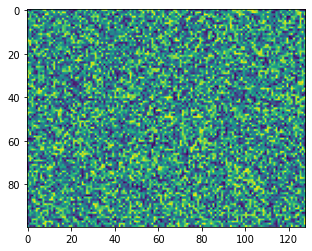

In [2]:
plt.imshow(test_input[0])

In [3]:
cwd = os.getcwd()
print(cwd)

/ocean/projects/iri120008p/billyli/AllaboutAudioSet/src


In [4]:
# from os import walk
# print(os.path.dirname('./'))
# os.getcwd(path)

# f = []
# for (dirpath, dirnames, filenames) in walk(os.path.dirname('../../pretrained_models/')):
#     f.extend(filenames)
#     break
# print(f)

In [5]:
os.path.exists('/ocean/projects/iri120008p/billyli/ast/pretrained_models/audioset_10_10_0.4593.pth')

True

In [3]:
# create an AST model
ast_mdl = ASTModel(label_dim=label_dim, input_tdim=input_tdim, imagenet_pretrain=True, audioset_pretrain=True)
test_output = ast_mdl(test_input)
# output should be in shape [10, 527], i.e., 10 samples, each with prediction of 527 classes.
print(test_output.shape)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True
I got here!
frequncey stride=10, time stride=10
number of patches=108
torch.Size([10, 527])


In [8]:
print(test_output)

tensor([[-0.4360, -0.1358, -0.0243,  ...,  0.0329,  1.1988, -0.0707],
        [-0.3618, -0.0538, -0.0706,  ...,  0.1613,  1.0444,  0.0607],
        [-0.4335, -0.0256, -0.0503,  ...,  0.1352,  1.1111, -0.0015],
        ...,
        [-0.4608, -0.0580, -0.0153,  ...,  0.1196,  1.1137, -0.0742],
        [-0.4389, -0.1896, -0.1474,  ...,  0.1480,  1.1699, -0.0370],
        [-0.3879, -0.1322, -0.0219,  ...,  0.1140,  1.2380, -0.0254]],
       grad_fn=<AddmmBackward0>)


In [4]:
print(test_output.shape)

torch.Size([10, 527])


In [5]:
def validate(audio_model, val_loader, args, epoch):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_time = AverageMeter()
    if not isinstance(audio_model, nn.DataParallel):
        audio_model = nn.DataParallel(audio_model)
    audio_model = audio_model.to(device)
    # switch to evaluate mode
    audio_model.eval()

    end = time.time()
    A_predictions = []
    A_targets = []
    A_loss = []
    with torch.no_grad():
        for i, (audio_input, labels) in enumerate(val_loader):
            audio_input = audio_input.to(device)

            # compute output
            audio_output = audio_model(audio_input)
            audio_output = torch.sigmoid(audio_output)
            predictions = audio_output.to('cpu').detach()

            A_predictions.append(predictions)
            A_targets.append(labels)

            # compute the loss
            labels = labels.to(device)
            if isinstance(args.loss_fn, torch.nn.CrossEntropyLoss):
                loss = args.loss_fn(audio_output, torch.argmax(labels.long(), axis=1))
            else:
                loss = args.loss_fn(audio_output, labels)
            A_loss.append(loss.to('cpu').detach())

            batch_time.update(time.time() - end)
            end = time.time()

        audio_output = torch.cat(A_predictions)
        target = torch.cat(A_targets)
        loss = np.mean(A_loss)
        stats = calculate_stats(audio_output, target)

        # save the prediction here
        exp_dir = args.exp_dir
        if os.path.exists(exp_dir+'/predictions') == False:
            os.mkdir(exp_dir+'/predictions')
            np.savetxt(exp_dir+'/predictions/target.csv', target, delimiter=',')
        np.savetxt(exp_dir+'/predictions/predictions_' + str(epoch) + '.csv', audio_output, delimiter=',')

    return stats, loss

In [ ]:
eval_loader = torch.utils.data.DataLoader(
        dataloader.AudiosetDataset(args.data_eval, label_csv='./data/class_labels_indices.csv', audio_conf=val_audio_conf),
        batch_size=args.batch_size*2, shuffle=False, num_workers=args.num_workers, pin_memory=True)
    stats, _ = validate(audio_model, eval_loader, args, 'eval_set')

In [ ]:
mAP = np.mean([stat['AP'] for stat in stats])
        mAUC = np.mean([stat['auc'] for stat in stats])
        middle_ps = [stat['precisions'][int(len(stat['precisions'])/2)] for stat in stats]
        middle_rs = [stat['recalls'][int(len(stat['recalls'])/2)] for stat in stats]
        average_precision = np.mean(middle_ps)
        average_recall = np.mean(middle_rs)
        wa_result = [mAP, mAUC, average_precision, average_recall, d_prime(mAUC)]
        print('---------------Training Finished---------------')
        print('weighted averaged model results')
        print("mAP: {:.6f}".format(mAP))
        print("AUC: {:.6f}".format(mAUC))
        print("Avg Precision: {:.6f}".format(average_precision))
        print("Avg Recall: {:.6f}".format(average_recall))
        print("d_prime: {:.6f}".format(d_prime(mAUC)))
        print("train_loss: {:.6f}".format(loss_meter.avg))
        print("valid_loss: {:.6f}".format(valid_loss))